In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(0)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetAltura/train
# !mkdir ../datasetAltura/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetAltura'),
#                 image.replace('datasetClean','../datasetAltura/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetAltura'),
#                 image.replace('datasetClean','../datasetAltura/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
def getDataBlock(presize=224,size=224):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_volumen,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True), Normalize.from_stats(*imagenet_stats)])

In [13]:
path = Path('../datasetAltura2/')
trainPath = path/'train'

In [14]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=16)

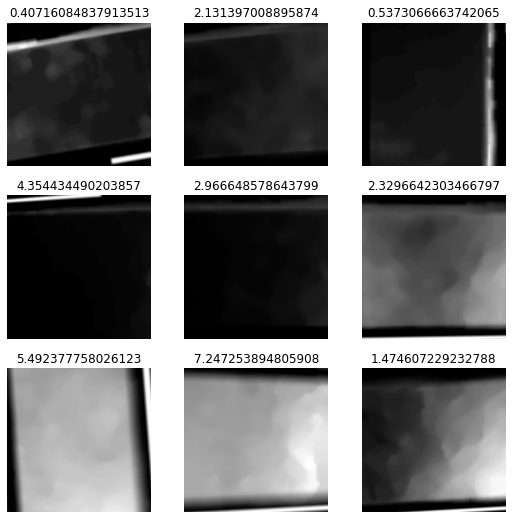

In [15]:
dls.show_batch()

In [16]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnetrs50VolumenHeight')
]

In [17]:
from fastai.metrics import mae,rmse,mse

In [18]:
learn = Learner(dls, timm.create_model('resnetrs50',num_classes=1,pretrained=True),
                loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,13.233444,6.778889,2.371935,2.603630,6.778889,00:05


Better model found at epoch 0 with valid_loss value: 6.778888702392578.


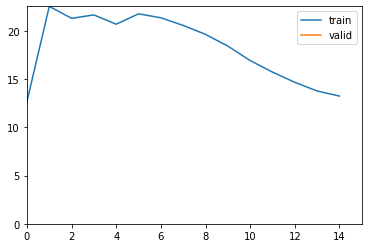

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,2.682758,1.767105,1.162590,1.329325,1.767105,00:03
1,2.289136,1.272111,0.826490,1.127879,1.272111,00:04
2,2.194921,1.373302,0.821982,1.171880,1.373302,00:04
3,1.969012,0.929863,0.769998,0.964294,0.929863,00:04
4,1.842879,0.261802,0.434270,0.511666,0.261802,00:04
5,1.805799,0.674840,0.666533,0.821487,0.674840,00:04
6,1.733643,0.715096,0.639898,0.845633,0.715096,00:04
7,1.622849,1.293059,0.938523,1.137128,1.293059,00:04
8,1.536846,0.553626,0.513783,0.744060,0.553626,00:04
9,1.489574,0.248007,0.407480,0.498003,0.248007,00:03


Better model found at epoch 0 with valid_loss value: 1.7671051025390625.


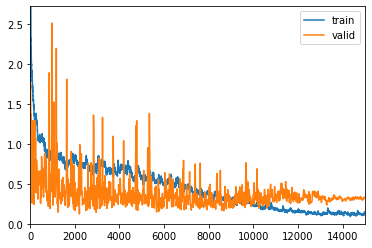

Better model found at epoch 1 with valid_loss value: 1.2721105813980103.
Better model found at epoch 3 with valid_loss value: 0.9298630952835083.
Better model found at epoch 4 with valid_loss value: 0.2618020176887512.
Better model found at epoch 9 with valid_loss value: 0.24800701439380646.
Better model found at epoch 11 with valid_loss value: 0.24655850231647491.
Better model found at epoch 53 with valid_loss value: 0.2209765762090683.
Better model found at epoch 58 with valid_loss value: 0.19257494807243347.
Better model found at epoch 82 with valid_loss value: 0.1453377902507782.
Better model found at epoch 146 with valid_loss value: 0.1226181834936142.


In [20]:
learn.fine_tune(1000,base_lr=1e-3)

In [21]:
# learn.load('resnetrs50Masav2Height')

In [22]:
# df[df['image_id']=='datasetClean/br_2022-01-07T10-54-11.tif']

In [23]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [24]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_volumen,
                 item_tfms = Resize(224),
                 batch_tfms=[*aug_transforms(size=224,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [25]:
dlstest = dbtest.dataloaders(path,bs=16)

In [26]:
learn.dls=dlstest

In [27]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.31809520721435547.


(#4) [0.1693406105041504,0.31809520721435547,0.4115101099014282,0.1693406105041504]

In [28]:
from sklearn.metrics import mean_absolute_error

In [29]:
preds,gt = learn.tta()

In [30]:
mean_absolute_error(gt,preds)

0.35379004